# Boulder First Snow

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import ultraplot as plot
import seaborn as sb
import pint_xarray
import datetime

today = datetime.date.today()
CURRENT_YEAR = today.year

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv("../data/boulder_daily_weather.csv")

<IPython.core.display.Javascript object>

In [4]:
# Snow totals do not start until August 1948.
data = data[data.year >= 1948]

<IPython.core.display.Javascript object>

In [5]:
datetime = []
for index, row in data.iterrows():
    # ESRL has a leap year every year (Feb 29th) but puts missing data for non
    # leap years. This makes the datetime conversion a little easier.
    datetime.append(cftime.DatetimeAllLeap(row["year"], row["mon"], row["day"]))

<IPython.core.display.Javascript object>

In [6]:
ds = xr.DataArray(data["snow (in)"], dims=["time"], coords=[datetime]).rename("snow").pint.quantify("inches")

<IPython.core.display.Javascript object>

In [7]:
# Get rid of trace amounts or no snow -- convert to NaN.
ds = ds.where(ds >= 0)

<IPython.core.display.Javascript object>

No snow has fallen in July or August since 1948. (Showing the total sum inches for each month)

In [8]:
ds.groupby("time.month").sum("time")

Magnitude,[803.0 945.7 1195.9 883.5999999999999 136.39999999999998 2.3000000000000003 0.0 0.0 88.0 411.1 871.0999999999999 854.0]
Units,inch


<IPython.core.display.Javascript object>

Can safely find the "first snow" by looking at the September - December range for each year.

In [9]:
def find_first_snow(ds, year):
    """Finds the cftime date of the first snow of the given year.

    Args:
        ds (xr.DataArray or xr.Dataset): xarray object with daily
            time coordinate and values as snow totals.
        year (int): Year being assessed for first snow.

    Returns:
        cfdate of first snow for the given year.
    """
    if year == 1989:
        return np.nan
    # Per NOAA website, there is an error in their data for this year.
    elif year == 1978:
        return cftime.DatetimeAllLeap(1978, 10, 23, 0, 0, 0)
    # Their data shows 0.08in snow on August 1st for some reason. Sep 8th
    # was certainly the first snow last year.
    elif year == 2020:
        return cftime.DatetimeAllLeap(2020, 9, 8, 0, 0, 0)
    # Put latest year in manually since the database is not yet updated.
    elif year == 2022:
        return cftime.DatetimeAllLeap(2022, 10, 27, 0, 0, 0)
    # Feeling lazy in 2023 and just going to manually add it again.
    elif year == 2023:
        return cftime.DatetimeAllLeap(2023, 10, 28, 0, 0, 0)
    # Alright, conintinuing to be lazy here. Need to update the CSV :)
    elif year == 2024:
        return cftime.DatetimeAllLeap(2024, 11, 4, 0, 0, 0)
    elif year == 2025:
        return cftime.DatetimeAllLeap(2025, 11, 29, 0, 0, 0)
    annual_subset = ds.sel(time=slice(f"{year}-08", f"{year}-12"))
    try:
        idx = (annual_subset > 0).argmax("time")
        cfdate = annual_subset["time"].to_index()[int(idx)]
    except ValueError:
        cfdate = np.nan
    return cfdate

<IPython.core.display.Javascript object>

In [10]:
result = [find_first_snow(ds, year) for year in np.arange(1948, CURRENT_YEAR + 1)]
result = xr.DataArray(result, dims=["year"], coords=[np.arange(1948, CURRENT_YEAR + 1)])

<IPython.core.display.Javascript object>

In [11]:
# Remove missing data from 1989.
result = result.dropna("year")

<IPython.core.display.Javascript object>

In [12]:
# Get the month to separate into colors and dayofyear
# for plotting.
ymonth = result.to_index().month
yday = result.to_index().dayofyear

<IPython.core.display.Javascript object>

Alternative plot looking at distribution

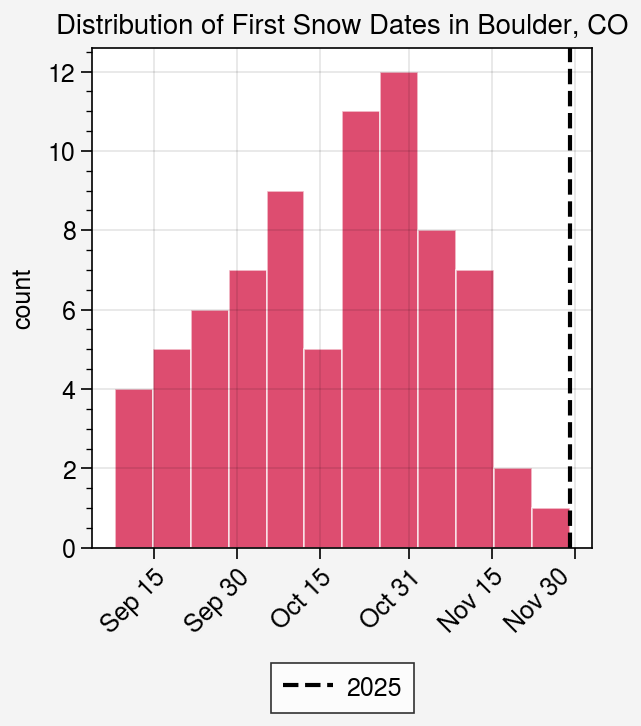

<IPython.core.display.Javascript object>

In [13]:
f, ax = plot.subplots()
ax.hist(yday, bins=12, color="cherry", edgecolor="white", alpha=0.7)
p = ax.axvline(yday[-1], color="black", linestyle="--", label="2025")

xticks = [245, 259, 274, 289, 305, 320, 335]
xticklabels = ["Sep 1", "Sep 15", "Sep 30", "Oct 15", "Oct 31", "Nov 15", "Nov 30"]

ax.format(
    ylabel="count",
    xticks=xticks,
    xticklabels=xticklabels,
    title="Distribution of First Snow Dates in Boulder, CO",
    xrotation=45,
)
f.legend(p, loc="b")
# f.savefig("../figures/snow.distribution.2025.png", transparent=False)

In [14]:
def plot_snow(ax, x, y, c, s=14, **kwargs):
    """Nice looking scatter plot for each month."""
    p = ax.scatter(x, y, s=s, c=c, zorder=4, **kwargs)
    return p

<IPython.core.display.Javascript object>

/var/folders/93/p0cpkqzs31j86_ccdhw8gzf00000gn/T/ipykernel_26623/3216812070.py:3: UltraPlotWarning: The rc setting 'large' was deprecated in version 0.6.0 and may be removed in the next major release (version 2.0.0). Please use 'font.largesize' instead.
  plot.rc.large = 11
/var/folders/93/p0cpkqzs31j86_ccdhw8gzf00000gn/T/ipykernel_26623/3216812070.py:4: UltraPlotWarning: The rc setting 'small' was deprecated in version 0.6.0 and may be removed in the next major release (version 2.0.0). Please use 'font.smallsize' instead.
  plot.rc.small = 9


Text(2025, 282, '     (Oct. 22nd)')

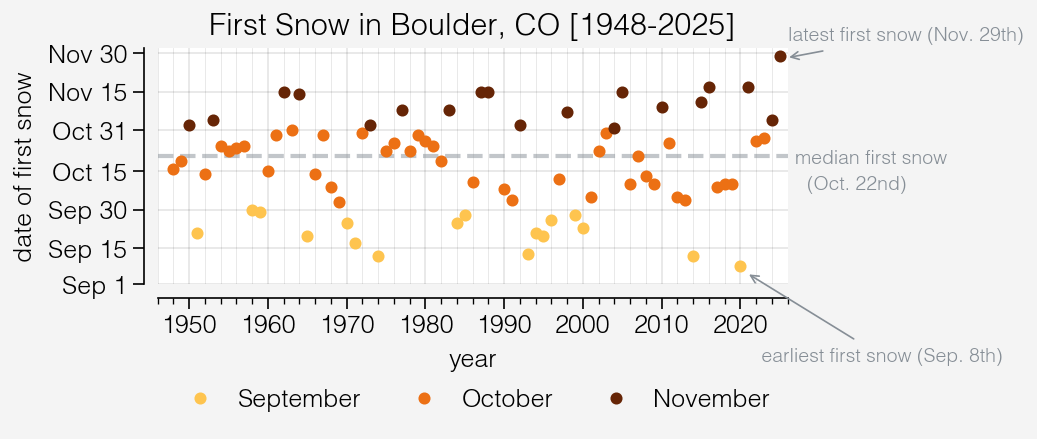

<IPython.core.display.Javascript object>

In [15]:
MONTH_COLORS = ["#fec44f", "#ec7014", "#662506"]

plot.rc.large = 11
plot.rc.small = 9
plot.rc.fontname = "Helvetica Light"
plot.rc["legend.frameon"] = False

f, ax = plot.subplots(axwidth="8cm", axheight="3cm")

x = result.year

p1 = plot_snow(ax, x[ymonth == 9], yday[ymonth == 9], c=MONTH_COLORS[0], label="September")
p2 = plot_snow(ax, x[ymonth == 10], yday[ymonth == 10], c=MONTH_COLORS[1], label="October")
p3 = plot_snow(ax, x[ymonth == 11], yday[ymonth == 11], c=MONTH_COLORS[2], label="November")

# Sep 1 to Dec 3 (needed to expand after crazy late 2025 snow)
ylim = [245, 337]

# Sep 1, Sep 15, Sep 30, Oct 15, Oct 31, Nov 15, Nov 30
yticks = [245, 259, 274, 289, 305, 320, 335]
yticklabels = ["Sep 1", "Sep 15", "Sep 30", "Oct 15", "Oct 31", "Nov 15", "Nov 30"]

# X limits
xlim = [1946, CURRENT_YEAR + 1]

ax.format(
    xlim=xlim,
    xlocator=10,
    xgridminor=True,
    ylim=ylim,
    yticks=yticks,
    ytickminor=False,
    yticklabels=yticklabels,
    ylabel="date of first snow",
    title=f"First Snow in Boulder, CO [1948-{CURRENT_YEAR}]",
)

# Latest snow annotation (2 dates)
ax.annotate(
    "latest first snow (Nov. 29th)",
    xy=(2025.5, 333),
    xytext=(2026, 340),
    fontsize=7,
    color="gray6",
    arrowprops=dict(arrowstyle="->", facecolor="gray6", edgecolor="gray6"),
)

# # Earliest snow annotation
ax.annotate(
    " earliest first snow (Sep. 8th) ",
    xy=(2020.5, 250),
    xytext=(2022, 215),
    fontsize=7,
    color="gray6",
    arrowprops=dict(arrowstyle="->", facecolor="gray6", edgecolor="gray6"),
)

# Can this be done through proplot?
sb.despine(
    offset=5,
)

# Legend
ax.legend(
    [
        p1,
        p2,
        p3,
    ],
    loc="b",
    center=True,
)

MEDIAN = int(np.median(result.to_index().dayofyear))
ax.axhline(MEDIAN, color="gray6", linestyle="--", alpha=0.5, linewidth=1.5)
ax.text(CURRENT_YEAR + 2, 292, "median first snow", fontsize=7, color="gray6")
# Just manually grabbing this... use leapyear dayofyear since we are doing AllLeap.
ax.text(2025, 282, "     (Oct. 22nd)", fontsize=7, color="gray6")

# This year
# ax.annotate(
#     " Oct. 28th, 2023 ",
#     xy=(2023.5, 301),
#     xytext=(2029, 310),
#     fontsize=7,
#     color="gray6",
#     arrowprops=dict(arrowstyle="->", facecolor="gray6", edgecolor="gray6"),
# )

# f.savefig("../figures/first.snow.2025.whitebg.png", transparent=False)